# <font color = green> PROCESSAMENTO DE IMAGENS BIOMÉDICAS </font>

In [2]:
import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np

import pydicom
from pydicom.data import get_testdata_files
from pydicom.data.data_manager import get_files

## <font color = green> TESTANDO A LIB PYDICOM </font>

In [ ]:
# Para abrir apenas uma imagem DICOM, podemos utilizar o get_files 
# path = "CINTILOGRAFIAS/BMT/P1A"
# dicom = "D405923.dcm"
# filename = get_files(path, dicom)[0]

In [ ]:
# Le e retorna um dataset
# ds = pydicom.dcmread(filename)

In [ ]:
# ds.PatientName

In [ ]:
# ds

In [ ]:
# Para verificarmos  a matriz da imagem utilizamos o pixel_array
# ds.pixel_array

## <font color = green> ABERTURA DAS IMAGENS </font>

### Salvando a matriz das imagens em duas listas que representam as classes 

In [4]:
bmt = []
graves = []

paths = glob.glob("CINTILOGRAFIAS/BMT/P*A/*.dcm")
for path in paths:
    dataset = pydicom.dcmread(path)
    bmt.append(dataset.pixel_array)
    
paths = glob.glob("CINTILOGRAFIAS/GRAVES/P*A/*.dcm")
for path in paths:
    dataset = pydicom.dcmread(path)
    graves.append(dataset.pixel_array)

### Visualizacao

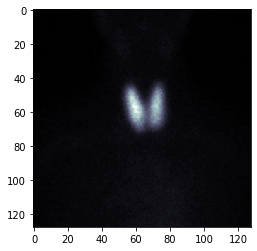

In [5]:
plt.imshow(graves[0], cmap=plt.cm.bone) 

### Salvando a imagem em JPG

In [ ]:
# plt.imsave('bmt06.png', bmt[6])

## <font color = green> PRÉ-PROCESSAMENTO </font>

### Segmentacao da regiao de interesse
#### Como todas as imagens possuem tamanho padrão de 128x128 o corte será realizado no centro da imagem. O slice começará no pixel 32 e terminará no 96, para ambas as dimensões. 

In [6]:
# Graves
for index, image in enumerate(graves):
    # Calculando o tamanho da nova imagem
    altura, largura = int((image.shape[1]) / 2), int((image.shape[0]) / 2)
    inicio = int(altura/2)
    fim = int((image.shape[0]) - inicio)
    
    # Realizando o corte
    cropped_image = image[inicio:fim, inicio:fim]
    
    # Salvando a nova imagem no vetor
    graves[index] = cropped_image

# BMT
for index, image in enumerate(bmt):
    # Calculando o tamanho da nova imagem
    altura, largura = int((image.shape[1]) / 2), int((image.shape[0]) / 2)
    inicio = int(altura/2)
    fim = int((image.shape[0]) - inicio)
    
    # Realizando o corte
    cropped_image = image[inicio:fim, inicio:fim]
    
    # Salvando a nova imagem no vetor
    bmt[index] = cropped_image

### Reducao de ruído

In [5]:
# Graves
for index, image in enumerate(graves):
    graves[index] = cv2.GaussianBlur(image, (5,5), 0)
    plt.imsave('pos-processamento/grave' + str(index) + '.jpg', graves[index], cmap='gray')

# BMT
for index, image in enumerate(bmt):
    bmt[index] = cv2.GaussianBlur(image, (5,5), 0)
    plt.imsave('pos-processamento/bmt' + str(index) + '.jpg', bmt[index], cmap='gray')

## <font color = green> HISTOGRAMA </font>

#### Intensidade do maior pixel da imagem

In [6]:
# for index, image in enumerate(graves):
#     print(graves[index].max())

### Um histograma por classe
#### cv2.calcHist (image, channel, mask, histSize, histRange)

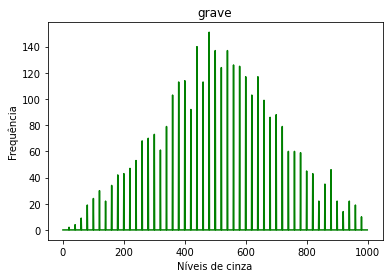

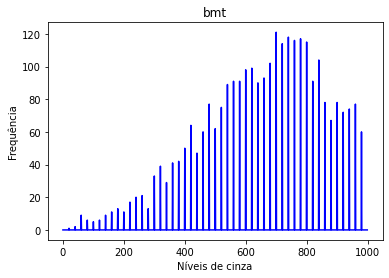

In [7]:
hist_graves = cv2.calcHist (graves, [0], None, [1000], [0, 50])
hist_bmt = cv2.calcHist (bmt, [0], None, [1000], [0, 50])

plt.figure()
plt.title('grave')
plt.xlabel("Níveis de cinza")
plt.ylabel("Frequência")
plt.plot(hist_graves, color = 'green')  
plt.savefig('histogramas/grave_class.png')

plt.figure()
plt.title('bmt')
plt.xlabel("Níveis de cinza")
plt.ylabel("Frequência")
plt.plot(hist_bmt, color = 'blue')  
plt.savefig('histogramas/bmt_class.png')

### Comparando os dois histogramas

In [8]:
compare = cv2.compareHist(hist_graves, hist_bmt, cv2.HISTCMP_CORREL)

In [9]:
compare

0.7966029660488507

## <font color = green> SEGMENTAÇÃO E CONTORNO </font>

In [11]:
# Graves
print("\nGRAVE")
for index, image in enumerate(graves):
    # Threshold
    thresh = cv2.threshold(graves[index], 100, 200, cv2.THRESH_BINARY)[1]
    thresh = thresh.astype(np.uint8)
    plt.imsave('segmentacao/graves' + str(index) + '.jpg', thresh, cmap='gray')
    
    # Contours
    cnt = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1]
    image_copy = graves[index].copy()
    cnt_image = cv2.drawContours(image=image_copy, contours=cnt, contourIdx=-1, color=(255, 0, 0), thickness=1, lineType=cv2.LINE_AA)
    plt.imsave('contorno/graves' + str(index) + '.jpg', cnt_image, cmap=plt.cm.bone)
    
    print("Imagem:", index)
    print("Número de objetos:",  len(cnt))
    
    # Area
    if len(cnt) > 0:
        cnt = cnt[0]
        area = cv2.contourArea(cnt)
        print("Área:", area, "\n")
    else:
        print (0.0)

# BMT
print("\nBMT")
for index, image in enumerate(bmt):
    # Threshold
    thresh = cv2.threshold(bmt[index], 130, 200, cv2.THRESH_BINARY)[1]
    thresh = thresh.astype(np.uint8)
    plt.imsave('segmentacao/bmt' + str(index) + '.jpg', thresh, cmap='gray')
        
    # Contours
    cnt = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1]
    image_copy = bmt[index].copy()
    cnt_image = cv2.drawContours(image=image_copy, contours=cnt, contourIdx=-1, color=(255, 0, 0), thickness=1, lineType=cv2.LINE_AA)
    plt.imsave('contorno/bmt' + str(index) + '.jpg', cnt_image, cmap=plt.cm.bone)
    
    print("Imagem:", index)
    print("Número de objetos:",  len(cnt))
    
    # Area
    if len(cnt) > 0:
        cnt = cnt[0]
        area = cv2.contourArea(cnt)
        print("Área:", area, "\n")
    else:
        print("Área:", 0.0, "\n")


GRAVE
Imagem: 0
Número de objetos: 1
Área: 549.0 

Imagem: 1
Número de objetos: 1
Área: 426.0 

Imagem: 2
Número de objetos: 1
Área: 407.5 

Imagem: 3
Número de objetos: 1
Área: 660.0 

Imagem: 4
Número de objetos: 1
Área: 419.0 

Imagem: 5
Número de objetos: 1
Área: 675.5 


BMT
Imagem: 0
Número de objetos: 2
Área: 33.0 

Imagem: 1
Número de objetos: 2
Área: 48.5 

Imagem: 2
Número de objetos: 0
Área: 0.0 

Imagem: 3
Número de objetos: 0
Área: 0.0 

Imagem: 4
Número de objetos: 2
Área: 64.0 

Imagem: 5
Número de objetos: 1
Área: 437.5 



## <font color = green> Extração de Características </font>

In [22]:
def calcula_contorno(images):
    areas = []
    objetos = []
    for image in images:
        # Threshold
        thresh = cv2.threshold(image, 130, 200, cv2.THRESH_BINARY)[1]
        thresh = thresh.astype(np.uint8)
            
        # Contours
        cnt = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
       
        # Area
        if len(cnt) > 0:
            cnt = cnt[0]
            area = cv2.contourArea(cnt)

        else:
            area = 0.0

        areas.append(area)
        objetos.append(len(cnt))

    return areas, objetos 

areas_bmt, objetos_bmt = calcula_contorno(bmt)
areas_graves, objetos_graves = calcula_contorno(graves)

print('Areas BMT: ', areas_bmt)
print('Areas graves: ', areas_graves)

print('Objetos BMT: ', objetos_bmt)
print('Objetos graves: ', objetos_graves) 

Areas BMT:  [62.5, 35.0, 0.0, 0.0, 0.0, 428.5]
Areas graves:  [468.0, 580.5, 139.5, 318.5, 598.5, 0.0]
Objetos BMT:  [19, 22, 0, 1, 0, 48]
Objetos graves:  [60, 41, 27, 58, 51, 1]


In [28]:
def calcula_histogramas(images):
    histogramas = []
    for img in images:
        hist = cv2.calcHist(img, [0], None, [1000], [0, 50])
        histogramas.append(hist)
    
    return histogramas 

hists_bmt = calcula_histogramas(bmt)
hists_graves = calcula_histogramas(graves) 

print('histogramas bmt: ', np.array(hists_bmt).shape)
print('histogramas graves: ', np.array(hists_graves).shape)

histogramas bmt:  (6, 1000, 1)
histogramas graves:  (6, 1000, 1)


Vetor de caracteristicas

In [30]:
# for index, image in enumerate(bmt):


# areas_bmt + objetos_bmt + hists_bmt 
# areas_graves + objetos_graves + hists_bmt
hists_bmt[0]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],